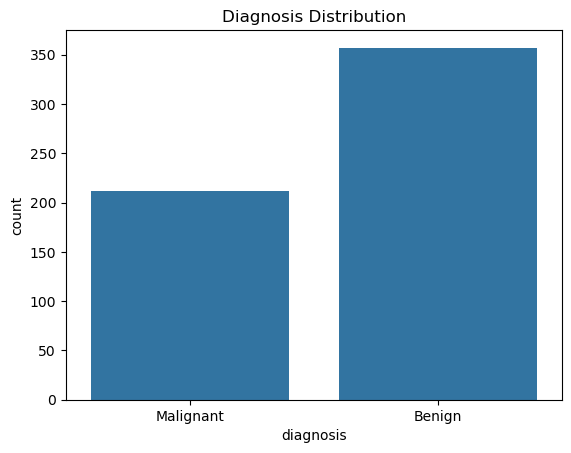

     Model                                         Features       AUC   LogLoss
0  Model 1                   [texture_mean, concavity_mean]  0.962660  0.269368
1  Model 2        [texture_mean, concavity_mean, area_mean]  0.990501  0.157512
2  Model 3  [texture_mean, concavity_mean, smoothness_mean]  0.962987  0.264801
3  Model 4      [texture_mean, concavity_mean, radius_mean]  0.990174  0.154208
4  Model 5    [texture_mean, concavity_mean, symmetry_mean]  0.962332  0.271317

Final Model Evaluation on Test Set
Confusion Matrix:
 [[67  5]
 [ 5 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        72
           1       0.88      0.88      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114

Test AUC: 0.9825


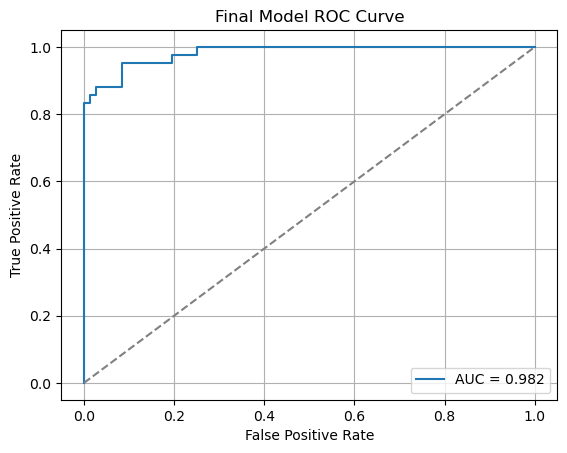


Final Model Equation:
logit(p) = -0.47 0.82*texture_mean + 1.29*concavity_mean + 2.29*radius_mean


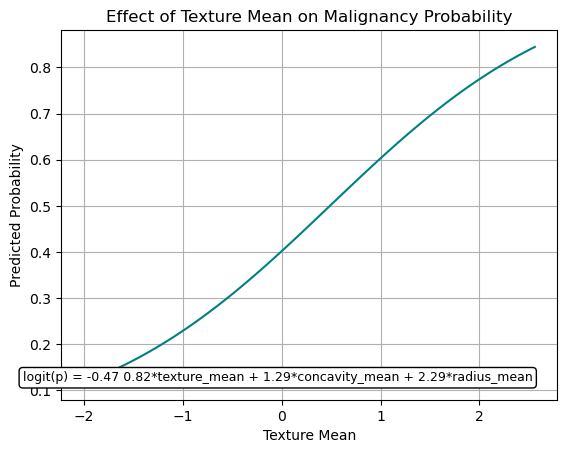

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv("C:/Users/lukew/Downloads/Cancer_Data.csv")

# Data Prep
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

# Features and split
X = df.drop(columns='diagnosis')
y = df['diagnosis']

# Split into train (60%), validation (20%), test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Exploratory Plot
sns.countplot(x='diagnosis', data=df.replace({0: 'Benign', 1: 'Malignant'}))
plt.title("Diagnosis Distribution")
plt.show()

# Model List
feature_sets = {
    'Model 1': ['texture_mean', 'concavity_mean'],
    'Model 2': ['texture_mean', 'concavity_mean', 'area_mean'],
    'Model 3': ['texture_mean', 'concavity_mean', 'smoothness_mean'],
    'Model 4': ['texture_mean', 'concavity_mean', 'radius_mean'],
    'Model 5': ['texture_mean', 'concavity_mean', 'symmetry_mean']
}

model_results = []

# Fit and evaluate on validation set
for name, features in feature_sets.items():
    X_val_subset = X_val_df[features]
    X_train_subset = X_train_df[features]
    
    model = LogisticRegression()
    model.fit(X_train_subset, y_train)
    probs = model.predict_proba(X_val_subset)[:, 1]
    preds = model.predict(X_val_subset)
    
    auc = roc_auc_score(y_val, probs)
    loss = log_loss(y_val, probs)
    cm = confusion_matrix(y_val, preds)
    
    model_results.append({
        'Model': name,
        'Features': features,
        'AUC': auc,
        'LogLoss': loss,
        'ConfusionMatrix': cm
    })

# Display results
results_df = pd.DataFrame(model_results)
print(results_df[['Model', 'Features', 'AUC', 'LogLoss']])

# Pick best model (Model 4)
best_features = feature_sets['Model 4']
final_model = LogisticRegression()
final_model.fit(X_val_df[best_features], y_val)

# Final model evaluation on test set
test_probs = final_model.predict_proba(X_test_df[best_features])[:, 1]
test_preds = final_model.predict(X_test_df[best_features])
auc_test = roc_auc_score(y_test, test_probs)
cm_test = confusion_matrix(y_test, test_preds)

print("\nFinal Model Evaluation on Test Set")
print("Confusion Matrix:\n", cm_test)
print("\nClassification Report:\n", classification_report(y_test, test_preds))
print("Test AUC:", round(auc_test, 4))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Print regression equation
intercept = final_model.intercept_[0]
coefs = final_model.coef_[0]
equation = f"logit(p) = {intercept:.2f} " + " + ".join([f"{coefs[i]:.2f}*{f}" for i, f in enumerate(best_features)])
print("\nFinal Model Equation:")
print(equation)

# Plot texture effect
texture_range = np.linspace(X_test_df['texture_mean'].min(), X_test_df['texture_mean'].max(), 100)
new_data = pd.DataFrame({
    'texture_mean': texture_range,
    'concavity_mean': X_test_df['concavity_mean'].mean(),
    'radius_mean': X_test_df['radius_mean'].mean()
})
new_probs = final_model.predict_proba(new_data)[:, 1]

plt.plot(texture_range, new_probs, color='teal')
plt.xlabel("Texture Mean")
plt.ylabel("Predicted Probability")
plt.title("Effect of Texture Mean on Malignancy Probability")
plt.annotate(equation, xy=(0.95, 0.05), xycoords='axes fraction',
             ha='right', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()
